<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_06_regularization_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Regular Dropout

In [2]:
# Define a dropout instance and create some data
# define the probability
prob = 0.5 # default value

dropout = nn.Dropout(p=prob)
dropout

Dropout(p=0.5, inplace=False)

In [3]:
# Lets see what dropout returns
x = torch.ones(10)

y = dropout(x)
print(x)
print()
print(y) # y/(1-p), SCALED UP
print()
print(torch.mean(y))
# Independent probabilities

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([2., 0., 2., 2., 0., 2., 2., 0., 0., 2.])

tensor(1.2000)


In [4]:
# dropout is turned off when evaluating the model
dropout.eval()
# All lines within its identation will have dropout mode off
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [5]:
# Another way to use dropout is to use F.dropout()
dropout.eval()
y = F.dropout(x) # no need to specify instance: This turns dropout ON
print(y)
print()
print(torch.mean(y))

tensor([2., 0., 0., 0., 0., 2., 0., 2., 2., 2.])

tensor(1.)


In [6]:
# We can manually switch it off with F
y = F.dropout(x, training=False)
print(y)
print()
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor(1.)


In [7]:
# We can manually switch on using True which is default
y = F.dropout(x, training=True)
print(y)
print()
print(torch.mean(y))

tensor([2., 0., 2., 2., 0., 0., 0., 0., 0., 2.])

tensor(0.8000)


In [8]:
# When a model is switched to eval mode it stays in it until it is switched back to training mode

# swritch to training
dropout.train()
y = dropout(x)
print(y)
print()

# switch to eval mode: dropout is off now
dropout.eval()
y = dropout(x)
print(y)
print()

# dropout.train()
y = dropout(x) # will still be in eval unless dropout.train() is activated
print(y)
print()

# Turn it on
dropout.train()
y = dropout(x)
print(y)

tensor([2., 0., 2., 2., 0., 2., 0., 2., 2., 2.])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

tensor([0., 2., 2., 0., 2., 2., 2., 0., 0., 0.])


## Drop-Out Regularization

In [9]:
# The data is not linearly separable and DL is not necessary, but here we do it for practical purposes
nPerClust = 200

# define the angles
th = np.linspace(0, 4*np.pi, nPerClust)

# define the radii
r1 = 10
r2 = 15

# generate the data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3,
      r1*np.sin(th) + np.random.randn(nPerClust)]

b = [r2*np.cos(th) + np.random.randn(nPerClust),
     r2*np.sin(th) + np.random.randn(nPerClust)*3]

# Define the true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

[print(len(i)) for i in a]
print()
[print(len(i)) for i in b]
print()
print(labels_np.shape)

200
200

200
200

(400, 1)


In [10]:
for i in a:
    print(len(i))

200
200


In [11]:
# Concatenate into a single matrix
data_np = np.hstack((a,b)).T
print(data_np.shape)
print(data_np[:10,:])
# Convert to Tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

(400, 2)
[[10.92938372 -0.38689516]
 [10.09832699 -0.20793983]
 [19.1378466   2.79258254]
 [14.95650923  2.46974117]
 [12.14704934  2.69062502]
 [ 9.87565764  1.11984385]
 [ 7.75331458  2.6929788 ]
 [ 5.79583918  4.01933402]
 [10.5063988   5.70126618]
 [ 3.46654169  4.5264303 ]]


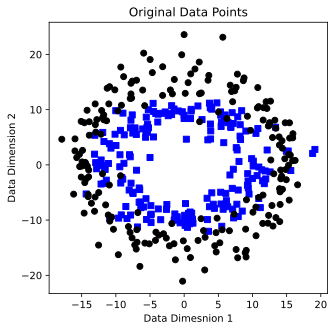

In [12]:
# Plot the whole thing
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], "bs")
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], "ko")
plt.title("Original Data Points")
plt.xlabel("Data Dimesnion 1")
plt.ylabel("Data Dimension 2")
plt.show()

In [13]:
# Separate the data into data loaders
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert them to pytpruch datasets, they are a;ready tensors
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Convert them to dataloader objects
batchsize=16 # int(train_data.tensors[0].shape[0]/4) for soft coding
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [14]:
test_data.tensors[0].shape[0]

80

In [15]:
# Create the model class
class theModelClass(nn.Module):
    def __init__(self,dropoutRate):
        super().__init__()

        # Layers
        self.input  = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128,1)

        # Parameters
        self.dr = dropoutRate

    # Define forward pass
    def forward(self,x):

        # Pass the data through the input layer
        x = F.relu(self.input(x))

        # Dropout after input layer
        # No need to set to true or false every time. 
        # This way it is set to true when model is on train mode and off otherwise
        x = F.dropout(x, p=self.dr, training=self.training) 

        # Pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # Dropout after hidden layer
        x = F.dropout(x, p=self.dr, training=self.training)

        # Outout layer
        # No dropout here
        x = self.output(x) 
        return x

In [16]:
# Test the model
tmpnet = theModelClass(0.25)

# Run some random data through. Untrained model, just checking whether it runs
tmpdata = torch.randn((10,2))
print(tmpdata)
print()
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.0766,  0.1225],
        [-0.2842, -1.1094],
        [ 1.2821, -1.6749],
        [-0.7696,  0.5777],
        [ 1.2708,  0.8284],
        [-0.3201, -0.1599],
        [ 0.1658, -1.5224],
        [-0.2276,  0.1440],
        [ 1.5001,  0.8834],
        [ 1.6176,  1.2402]])



tensor([[ 0.0668],
        [-0.1025],
        [-0.6298],
        [-0.2738],
        [-0.0069],
        [-0.0085],
        [-0.0893],
        [-0.0374],
        [-0.3168],
        [-0.1115]], grad_fn=<AddmmBackward0>)

## Create and Train the Network

In [17]:
def createANewModel(dropoutrate):

    # Grab an instance of the model class
    ANNQC = theModelClass(dropoutrate)

    # define the loss function
    lossfun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr = 0.002)

    return ANNQC, lossfun, optimizer

In [18]:
# Train the model
# Define the number of epochs
numepochs = 1000

def trainTheModel(ANNQC, lossfun, optimizer):

    # Initialize accuracies
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch training mode on
        ANNQC.train()

        # Loop over training data batches
        batchAcc = []
        for X,y in train_loader: # Minibatch

            # Forward pass and loss
            yHat = ANNQC(X)
            loss = lossfun(yHat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute batch accuracy
            batchAcc.append(100*torch.mean(((yHat>0.5)==y).float()).item())
        # End of batch loop

        # Now that we finished training throuh the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # Test Accuracy
        # Switch training off
        ANNQC.eval()
        # Extract data from test loader
        X,y = next(iter(test_loader))
        yHat = ANNQC(X)
        testAcc.append(100*torch.mean(((yHat >0.5)==y).float()).item())

    # Function putput
    return trainAcc, testAcc

In [19]:
# Time to test the model
dropoutrate = 0.0
ANNQC, lossfun, optimizer = createANewModel(dropoutrate)

# Train the model
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

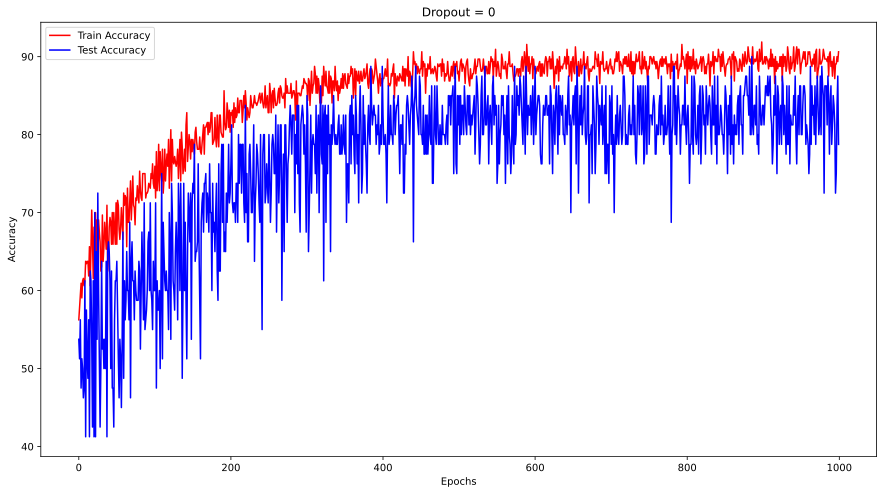

In [20]:
# Quick Visualization
fig = plt.figure(figsize=(15,8))
plt.plot(trainAcc, "r", label = "Train Accuracy")
plt.plot(testAcc, "b", label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Dropout = 0")
plt.legend()
plt.show()
# The jittery nature of the plot is related to batch size

In [21]:
# Create a 1D Smoothing filter
def smooth(x,k=5):
    return np.convolve(x, np.ones(k)/k, mode="same")

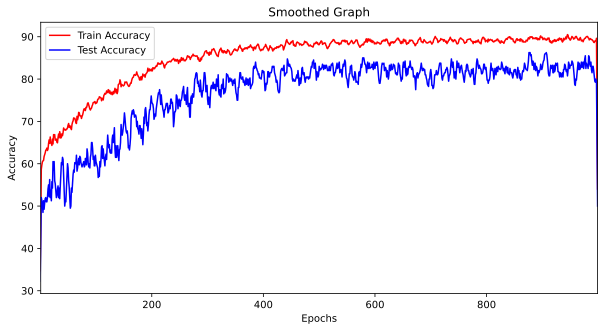

In [22]:
fig = plt.figure(figsize=(10,5))
plt.plot(smooth(trainAcc), "r", label = "Train Accuracy")
plt.plot(smooth(testAcc), "b", label = "Test Accuracy")
plt.xlim([1,999])
plt.title("Smoothed Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Run Experiment with Varying Dropout

In [23]:
dropoutRates = np.arange(10)/10

# empty array to store results
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # Create and train the model
    ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

    # Store accuracies from the last 100 epochs because there is not much change
    results[di,0] = np.mean(trainAcc[-100:])
    results[di,1] = np.mean(testAcc[-100:])

In [24]:
results

array([[89.728125  , 83.00000024],
       [83.515625  , 78.03750008],
       [78.9       , 62.92500019],
       [77.271875  , 43.37500012],
       [76.01875   , 41.2499994 ],
       [74.03125   , 41.2499994 ],
       [71.609375  , 40.0000006 ],
       [68.85625   , 40.0000006 ],
       [64.45      , 40.0000006 ],
       [58.85625   , 40.0000006 ]])

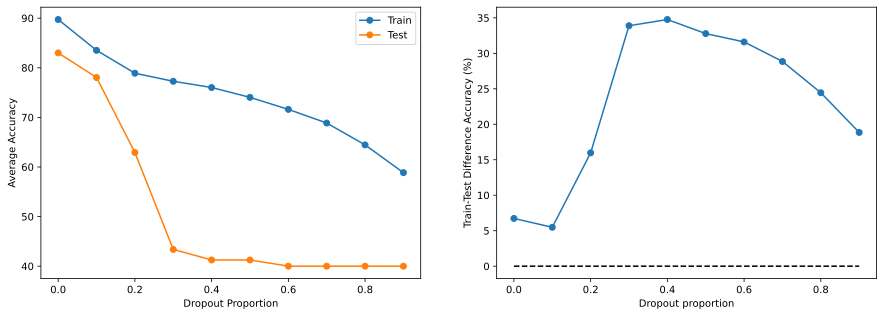

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, "o-")
ax[0].set_xlabel("Dropout Proportion")
ax[0].set_ylabel("Average Accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), "o-")
ax[1].plot([0,0.9], [0,0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-Test Difference Accuracy (%)")

plt.show()

# Increasing dropout rate makes performance worse because its a small model

# Dropout with Iris

In [26]:
# Import and convert iris dataset
import seaborn as sns
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [27]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()
data.shape

torch.Size([150, 4])

In [28]:
# Tranform species to numbers
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=="setosa"] = 0
labels[iris.species=="versicolor"] = 1
labels[iris.species=="virginica"] = 2
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [29]:
# Split the data into train-test and convert to dataloader
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert to PyTorch datasets
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# Translate into data loaders
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Create Model Class

In [30]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # Layers
        self.input = nn.Linear(4,12)
        self.hidden = nn.Linear(12,12)
        self.output = nn.Linear(12,3)

        # Parameters
        self.dr = dropoutRate

    # Forward Pass
    def forward(self,x):

        # input
        x = F.relu(self.input(x))
        x = F.dropout(x, p = self.dr, training=self.training)

        # Hidden
        x = F.relu(self.hidden(x))
        x = F.dropout(x, p = self.dr, training = self.training)

        # Outout
        x = self.output(x)
        return x

In [31]:
# Test to see that the model works without errors
# 3 output values expected
tmpnet = theModelClass(0.25)

tmpdata = torch.rand((10,4))
yHat = tmpnet(tmpdata)
yHat

tensor([[ 0.3006,  0.2291, -0.2266],
        [ 0.3324,  0.3267, -0.2066],
        [ 0.2187,  0.1902, -0.1821],
        [ 0.3454,  0.2592, -0.2766],
        [ 0.3364,  0.2934, -0.2084],
        [ 0.2820,  0.2356, -0.2259],
        [ 0.3483,  0.2204, -0.2381],
        [ 0.3133,  0.2970, -0.1881],
        [ 0.3646,  0.2868, -0.2607],
        [ 0.3321,  0.2503, -0.2274]], grad_fn=<AddmmBackward0>)

In [32]:
# Create the ANN Model
def createANewModel(dropoutrate):

    # Grab an instance of the model class
    ANNiris = theModelClass(dropoutrate)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.005)

    return ANNiris, lossfun, optimizer

In [33]:
# Train the model
# Set the number of epochs
numepochs = 500

def trainTheModel():

    # Initialize accuracies as empty lists
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Switch learning on
        ANNiris.train()

        # Loop over the training data batches
        batchAcc = []
        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training accuracy of a single batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        # End of batch loop
        
        # Obtain the average accuracy of the batches
        trainAcc.append(np.mean(batchAcc))

        # Test Accuracy
        ANNiris.eval()

        # No batches, single iteration
        X,y = next(iter(test_loader))
        # Get label predicitions
        predlabels = torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
    # Final Output
    return trainAcc, testAcc

In [34]:
# Create a single model
dropoutrate = 0.0
ANNiris, lossfun, optimizer = createANewModel(dropoutrate)

# Train the model
trainAcc, testAcc = trainTheModel()

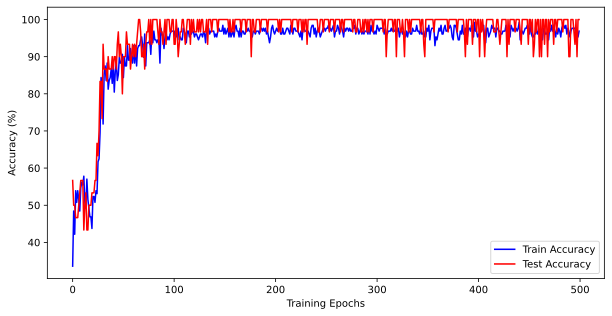

In [35]:
# Plot the whole thing
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc, "b", label = "Train Accuracy")
plt.plot(testAcc, "r", label = "Test Accuracy")
plt.legend()
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

In [36]:
# Lets explore the effect of dropout
dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    # Create new model every time
    ANNiris, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel()

    # Store the accuracies, take the average of the last 50 epochs only
    results[di,0] = np.mean(trainAcc[-50:])
    results[di,1] = np.mean(testAcc[-50:])

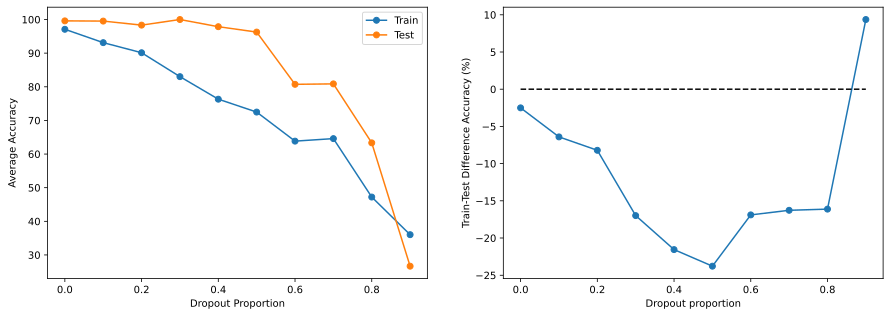

In [37]:
# Plot again
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(dropoutRates, results, "o-")
ax[0].set_xlabel("Dropout Proportion")
ax[0].set_ylabel("Average Accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis=1), "o-")
ax[1].plot([0,0.9], [0,0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-Test Difference Accuracy (%)")

plt.show()
# Again dropout makes it worse!
# Dropout regularization s not a good idea for smaller datasets and shallower models